# Lab 2

The aims of this lab are to:
 - Make your first recommendations using Spotlight recommender toolkit on explicit data
 - Start to think about explicit vs implicit learners
 - Evaluate your results using Spotlight

In [0]:
#Standard setup
import pandas as pd
import numpy as np
import torch

We're going to use the Spotlight library - see https://github.com/maciejkula/spotlight - and its documentation at https://maciejkula.github.io/spotlight/

We can install this direct from Git, but using Craig's patched version.


In [2]:
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight


  Cloning https://github.com/cmacdonald/spotlight.git (to revision master) to /tmp/pip-install-p_64kpn9/spotlight
  Running command git clone -q https://github.com/cmacdonald/spotlight.git /tmp/pip-install-p_64kpn9/spotlight
  Created wheel for spotlight: filename=spotlight-0.1.6-cp36-none-any.whl size=34184 sha256=c9e73b00ca733502f19c2cb580099fdca3b6e6081096b7ada1d2673c0fb4877d
  Stored in directory: /tmp/pip-ephem-wheel-cache-q6im_b1o/wheels/22/6f/f1/68cc6c5b563e78737e4a8fed63ddc105a3baf25d2abccae0c6
Successfully built spotlight


We'll be using Movielens again. Lets load it in to the dataframe.


In [3]:
!curl -o ml-latest-small.zip http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  2668k      0 --:--:-- --:--:-- --:--:-- 2668k
Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [0]:

ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
movies_df = pd.read_csv("ml-latest-small/movies.csv")


In [5]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [6]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


#Part 1 - Getting (Explicit) Rating Data into Spotlight and Analysing Outcomes

Now we can get onto some real recommendation work. Spotlight has a handy [Interactions](https://maciejkula.github.io/spotlight/interactions.html) object, which encapsulates the basics of a recommendations dataset.

In fact, there are handy loaders for a few standard datasets including MovieLens, but lets make our own, so that we can match back to the dataframe.

Interactions needs numbers as userids and itemids. Unfortunately, our MovieLens uses numbers, but these aren't consecutive (i.e. we have missing movieIds values). So, for both movies and users, we will use [defaultdict](https://docs.python.org/3/library/collections.html#collections.defaultdict) to convert the MovieLens integers down to consecutive integers for use in Spotlight, in the `uid_map` and `iid_map` objects. We'll keep the reverse mapping around too, in case we want to lookup the actual movieId given the uid recorded by Spotlight (etc). 

In [7]:
from collections import defaultdict
from itertools import count

uid_map = defaultdict(count().__next__)
iid_map = defaultdict(count().__next__)
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

print("userId %d got uid %d" % (556, uid_map[556]))
print("movieId %d got iid %d" % (54001, iid_map[54001]))

userId 556 got uid 555
movieId 54001 got iid 2518


Now lets built an [Interactions](https://maciejkula.github.io/spotlight/interactions.html) object from Spotlight. This contains everything that Spotlight needs to train a model. We can split it up randomly into train and test subsets.

In [0]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

dataset = Interactions(user_ids=uids,
                                  item_ids=iids,
                                  ratings=ratings,
                                  timestamps=timestamps)

#lets initialise the seed, so that its repeatable and reproducible 
train, test = random_train_test_split(dataset, random_state=np.random.seed(42))

Lets see how big the two datasets are. What is the train/test split percentage size?

In [9]:
print(train)
print(test)

<Interactions dataset (610 users x 9724 items x 80668 interactions)>
<Interactions dataset (610 users x 9724 items x 20168 interactions)>


Now, you can think of the Interactions objects are being the partitions of the rating matrix. But we dont store it as a single big matrix. Instead, we record three one-dimensional arrays:
 
  * one for the ids of the users
  * one for the ids of the items
  * one for the actual rating values.

Each of these arrays is the size of the number of ratings.

Lets take our favourite fantasy adventure fan, userId 556. We can give a look at their training ratings:

In [10]:
#map userId to the internal uid value
userId = 556
uid = uid_map.get(556)

#see which ratings are for this user. Use this to filter the item and ratings arrays
print(train.item_ids[train.user_ids == uid])
print(train.ratings[train.user_ids == uid])

[1925 6087 1894  774  926 2518 1893 1938  322  457  779  763  764 7951
  912 1342 1132 4796  753 3258 5989 8141  917 1077 8659 3076]
[5.  3.5 3.5 4.  4.  4.  4.  4.5 5.  5.  4.  4.5 4.  4.  2.5 4.  4.  4.
 4.5 4.  4.  3.5 3.5 5.  4.  4.5]


Right, now we can learn a model. Lets start with a matrix factorisation for explicit data.  We train the model using the `fit` method. This is just like the `fit` in Sklearn - we're fitting  a model to the specified training data.

This might take upto a minute. 

**NB:**  that Spotlight can support using GPUs which we could use to slightly speed up training time, that but will make our life more difficult later on, so lets ignore this for now.

In [11]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
import time  

emodel = ExplicitFactorizationModel(n_iter=10,
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False)
current = time.time()

emodel.fit(train, verbose=True)

end = time.time()
diff = end - current
print("Training took %d seconds "% (diff))

Epoch 0: loss 4.267401919900617
Epoch 1: loss 0.8179467064858992
Epoch 2: loss 0.5211602930403962
Epoch 3: loss 0.3746914708444589
Epoch 4: loss 0.2976520007264011
Epoch 5: loss 0.25625534379218196
Epoch 6: loss 0.23633310264801677
Epoch 7: loss 0.22111863647646543
Epoch 8: loss 0.21136369410006306
Epoch 9: loss 0.20499512873872927
Training took 21 seconds 


How well did we do. Well, lets give a look at the recommentations, for our specific user, userId 556. 



In [12]:
print("One test item_id for userId 556 (uid %d) is " % uid_map.get(556))

testItemId = test.item_ids[np.where(test.user_ids == uid_map.get(556))[0][0]]
print("Test movieId is %d itemId %d " % (iid_rev_map.get(testItemId), testItemId ) )


#here 0 is a dummy item, which Spotlight needs for some reason...
#we discard its prediction using [1]
predicted = emodel.predict( np.array([555]), item_ids=np.array([0, testItemId]))[1]

#what was the actual score of the user for that movie?
#we can get the appropriate row from the ratings dataframe, then extract that value
actual = ratings_df[(ratings_df.movieId==iid_rev_map.get(testItemId)) & (ratings_df.userId==556)][["rating"]].values[0][0]

print("Predicted rating was %f, actual rating %0.1f, error was %f" % (predicted, actual, abs(predicted-actual) )) 


One test item_id for userId 556 (uid 555) is 
Test movieId is 93363 itemId 6082 
Predicted rating was 3.974447, actual rating 4.0, error was 0.025553


We can also ask for **all** of the recommendations for a given user:

In [13]:
allpreds = emodel.predict( np.array([555]) )

print(allpreds)
print(allpreds.size)

#we can recover the original rating for movieId 48394
print(allpreds[1132])

[4.3072777 4.2970443 4.0454903 ... 2.3920205 0.8961684 3.7978797]
9724
5.0236225


Lets see how these recommendations are made. Remember from Lecture 9 that the prediction is made based on the dot product of the user's and item's latent factors.

We can access these embeddings directly from the emodel object. Each embedding has 32 dimensions, which is what we set when configuring Spotlight's Explicit Factorisation Model.

In [14]:
#these two statements are equivalent
#emodel._net.item_embeddings(torch.tensor([0]))

emodel._net.item_embeddings.weight[0]


tensor([-0.3539,  0.1294, -0.0125,  0.1018,  0.1166, -0.3958, -0.1623, -0.1122,
         0.2337, -0.3267, -0.2512,  0.4283,  0.2707, -0.3958, -0.4590, -0.3562,
        -0.3001,  0.2085,  0.2348,  0.8447, -1.0902,  0.6682, -0.3615,  0.0597,
         0.1080,  0.0219,  0.2227, -0.4413, -0.3092,  0.5955,  0.5630, -0.0283],
       grad_fn=<SelectBackward>)

We can check how Spotlight makes its prediction. The key line is https://github.com/maciejkula/spotlight/blob/master/spotlight/factorization/representations.py#L89

This takes the (dot-)product of the user's "embedding" (latent factor) and the item's embedding. On top of these are added "user_biases" and "item_biases". What do you think these last two components are for?

Lets reproduce this for our favourite user...

In [15]:
(
  (emodel._net.user_embeddings.weight[555] * emodel._net.item_embeddings.weight[1893]).sum(0) 
    + emodel._net.user_biases(torch.tensor([555]))  
    + emodel._net.item_biases(torch.tensor([1893]))

)

tensor([[3.7266]], grad_fn=<AddBackward0>)

**Exercise**

Lets give a look at item-item similarities. Write a function `mostsimilar(targetMovieId, model):` that identifies the most similar movieId to the specified target, based on the Cosine similarity of their item embedding vectors. 

What's the closest movie to "Harry Potter and the Deathly Hallows: Part 1 (2010)" , which is movieId 81834 in the MovieLens dataset?

In [16]:
import torch.nn as nn

def mostsimilar(targetMovieId, model):
  highest=0
  highestCos=0
  targetIId=iid_map.get(targetMovieId)
  
  #you may assume that model._num_items items.
  #nn.functional.cosine_similarity() allows you to calculate the cosine similarity between two vectors.
  
  
  ##SOLUTION FROM HERE
  # nn.functional.cosine_similarity()
  print(train)
  targetWeight = emodel._net.item_embeddings.weight[targetIId]
  for iid in train.item_ids:
    if iid == targetIId:
      continue
    weight = emodel._net.item_embeddings.weight[iid]
    cos = nn.functional.cosine_similarity(targetWeight, weight, dim=0)
    if highestCos < cos:
      highest = iid
      highestCos = cos
  

  print(train.num_items)
  print("targetMovieId = %d (iid %d)" % (targetMovieId, targetIId))
  print("mostSimilar = %d (iid %d) with cosine of %f " % ( iid_rev_map.get(highest), highest, highestCos))
  
  
mostsimilar(81834, emodel)

<Interactions dataset (610 users x 9724 items x 80668 interactions)>
9724
targetMovieId = 81834 (iid 1933)
mostSimilar = 69844 (iid 917) with cosine of 0.844179 


Finally, lets see how good we are at our rating predictions. Handily, Spotlight implements a few common evaluation measures for us to inspect.

In [17]:
from spotlight.evaluation import rmse_score

train_rmse = rmse_score(emodel, train)
test_rmse = rmse_score(emodel, test)

print('Train RMSE {:.3f}, test RMSE {:.3f}'.format(train_rmse, test_rmse))


Train RMSE 0.420, test RMSE 1.074


**Additional Exercise**:
Change one of the following parameters - does this make matrix factorisation more or less accurate at rating prediction?:

1. Increase the number of latent factors from 32 to 128
2. Decrease the number of training iterations.
3. Use `spotlight.cross_validation.user_based_train_test_split()` to split the data instead of a random split.

We can also project the item embeddings down into 2 dimensions using PCA (principal component analysis), for plotting on a figure (I followed the guidance at https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html). From the random selection of movies shown, are there discernable pattern in the points in this projection? 


explained variance ratio (first two components): [0.14808719 0.08055559]


<function matplotlib.pyplot.show>

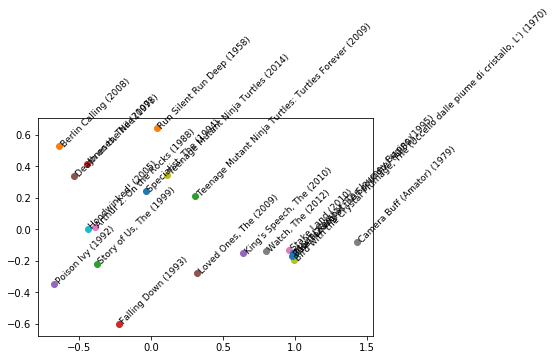

In [18]:
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
latent2D = pca.fit(emodel._net.item_embeddings.weight.detach().numpy()).transform(emodel._net.item_embeddings.weight.detach().numpy())

print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))


for i, title in enumerate(movies_df["title"]):
    if random.randint(1,1001) > 999:
      plt.scatter(latent2D[i,0], latent2D[i,1])
      plt.text(latent2D[i,0], latent2D[i,1], title, fontsize=9, rotation=45)
 
plt.show



# Part 2 - Implicit Recommendation

This part of the lab uses a music dataset from [Last.fm](https://www.last.fm/) -- a Spotify-like music streaming service -- that was obtained by a researcher at Pompeu Fabra University (Barcelona, Spain). The relevant citation is:

```
  @book{Celma:Springer2010,
      	author = {Celma, O.},
      	title = {{Music Recommendation and Discovery in the Long Tail}},
       	publisher = {Springer},
       	year = {2010}
      }
 ```

You see more information about the dataset at [this link](https://www.dtic.upf.edu/~ocelma/MusicRecommendationDataset/lastfm-1K.html)

## Dataset preparation

In [19]:
!rm -rf lastfm-dataset-1K.tar.gz
!curl -o "lastfm-dataset-1K.tar.gz" "http://www.dcs.gla.ac.uk/~craigm/recsysH/lastfm-dataset-1K.tar.gz"
!tar -zxvf lastfm-dataset-1K.tar.gz
!ls -lh lastfm-dataset-1K/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  641M  100  641M    0     0  27.9M      0  0:00:22  0:00:22 --:--:-- 29.5M
lastfm-dataset-1K/
lastfm-dataset-1K/userid-profile.tsv
lastfm-dataset-1K/README.txt
lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv
total 2.4G
-rw-r--r-- 1 1002 1002 2.2K Mar 23  2010 README.txt
-rw-r--r-- 1 1002 1002  37K Dec 30  2009 userid-profile.tsv
-rw-r--r-- 1 1002 1002 2.4G Mar  4  2010 userid-timestamp-artid-artname-traid-traname.tsv


In [0]:
listens_df = pd.read_csv(
    "lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv", 
    names=['user', 'timestamp', 'artistid', 'artist', 'trackid', 'trackname'], 
    header=None, sep='\t'
)


Lets look at the dataset. Note that the we dont have any explicit ratings by the users. We just know what they interacted with (and when). 

In [21]:
listens_df

,user,timestamp,artistid,artist,trackid,trackname
0,user_000001,2009-05-04T23:08:57Z,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04T13:54:10Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04T13:52:04Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04T13:42:52Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04T13:42:11Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)
...,...,...,...,...,...,...
19098857,user_001000,2008-01-27T22:02:35Z,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,a490cabc-1e5c-4807-86c7-740c31a50009,Please Be Patient With Me
19098858,user_001000,2008-01-27T21:56:52Z,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,3e92e447-9e1f-440d-bc00-6734469880c5,Shake It Off
19098859,user_001000,2008-01-27T21:52:36Z,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,93d044e6-1bbb-46a6-ac8e-283382a89e6f,Side With The Seeds
19098860,user_001000,2008-01-27T21:49:12Z,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,5ac4386f-6146-4389-a762-4b43f362d2c8,Sky Blue Sky


Actually, these artist and trackids are from [Musicbrainz](https://musicbrainz.org/), and not all artists/tracks have entries. 

***Exercise***
Count how many unique tracks do not have a musicbrainz trackid. Hint: You can use `len()` on a `groupby()`.

In [22]:
listens_df['trackid']

0                                            NaN
1                                            NaN
2                                            NaN
3                                            NaN
4                                            NaN
                            ...                 
19098857    a490cabc-1e5c-4807-86c7-740c31a50009
19098858    3e92e447-9e1f-440d-bc00-6734469880c5
19098859    93d044e6-1bbb-46a6-ac8e-283382a89e6f
19098860    5ac4386f-6146-4389-a762-4b43f362d2c8
19098861    3acc99bc-a349-420f-ad28-7095eb3533c9
Name: trackid, Length: 19098862, dtype: object

In [38]:
len(listens_df[listens_df['trackid'].isna()].groupby('trackname'))

19595

## An implicit recommendation approach

Lets move away from explicit recommendation to implicit.

We will continue using the [Spotlight](https://github.com/maciejkula/spotlight/) toolkit for our recommender. 

We can construct [Interaction](https://maciejkula.github.io/spotlight/interactions.html) objects for Spotlight in the same way as before. The only difference is that this time we do not record the user's ratings.


In [0]:
#Some tracks dont seem to have artists or track names, so lets drop them for simplicity.
listens_df = listens_df[listens_df.artist.notnull()]
listens_df = listens_df[listens_df.trackname.notnull()]

#the dataframe is VERY big (19M interactions), so lets just work with a small sample of it (this will mean that effectiveness will be lower, but learning will be MUCH faster).
listens_df = listens_df.sample(n=200000, random_state=42)

In [32]:
from collections import defaultdict
from itertools import count

#we cant trust the musicbrainz ids to exist, so lets build items ids based on artist & trackname attributes
iid_map = defaultdict(count().__next__)
iids = np.array([iid_map[artist+"/"+trackname] for artist,trackname in listens_df[["artist","trackname"]].values ], dtype=np.int32)


uid_map = defaultdict(count().__next__)
uids = np.array([uid_map[uid] for uid in listens_df["user"].values ], dtype=np.int32)

uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}

from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

#NB: we will set num_users and num_items here - its a good practice.
imp_dataset = Interactions(user_ids=uids, item_ids=iids, num_users=len(uid_map), num_items=len(iid_rev_map))
#we could add the timestamps here if we were doing sequence recommendation

#what have we got.
print(imp_dataset)

<Interactions dataset (971 users x 124842 items x 200000 interactions)>


In [33]:
from spotlight.cross_validation import random_train_test_split

itrain, itest = random_train_test_split(imp_dataset, random_state=np.random.seed(42))
print(itrain)
print(itest)

<Interactions dataset (971 users x 124842 items x 160000 interactions)>
<Interactions dataset (971 users x 124842 items x 40000 interactions)>


Let's run Spotlight's a impllicit Matrix Factorisation on this dataset. Here, we use a *pointwise* loss, which just tries to predict the item or not.

**Warning** this dataset is difficult for the learner - this *will* take a few minutes to learn... Use the time to read-on.

In [34]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  

imodel = ImplicitFactorizationModel(
    n_iter=5,
    embedding_dim=32, #this is Spotlight default
    use_cuda=False
    )
current = time.time()

imodel.fit(itrain, verbose=True)
end = time.time()
diff = end - current
print("Training took %d seconds" % (diff))

Epoch 0: loss 0.9662098599433899
Epoch 1: loss 0.4952331606388092
Epoch 2: loss 0.1897328441619873
Epoch 3: loss 0.11405178478956222
Epoch 4: loss 0.08251605984568595
Training took 176 seconds


Again, we can look at the predictions. We make a prediction (a score ) for ALL items. Note that the scores vary in magnitude - indeed, we're not predicting a rating, we just need to have scores in order to rank the in descending order.

In [35]:
print(imodel.predict(0))
print(len(imodel.predict(0)))

[ 6.171663   0.6499566 -7.3378167 ... -2.2506323 -7.31053   -1.5209415]
124842


Indeed, lets give a look at the distribution of scores. Its a fairly 'normal' distribution - there are very few items with high scores.

(array([1.0000e+00, 0.0000e+00, 4.0000e+00, 1.1000e+01, 5.0000e+01,
        8.3000e+01, 1.6100e+02, 3.8200e+02, 6.2500e+02, 1.2380e+03,
        1.9370e+03, 3.1950e+03, 4.8970e+03, 6.7660e+03, 9.1890e+03,
        1.0996e+04, 1.2730e+04, 1.3018e+04, 1.2968e+04, 1.1348e+04,
        9.6220e+03, 7.7050e+03, 5.8190e+03, 4.1490e+03, 2.7670e+03,
        1.9320e+03, 1.1830e+03, 7.1000e+02, 4.2900e+02, 2.6200e+02,
        1.5100e+02, 1.1800e+02, 1.8500e+02, 9.7000e+01, 6.1000e+01,
        2.7000e+01, 1.5000e+01, 6.0000e+00, 3.0000e+00, 2.0000e+00]),
 array([-21.15151   , -20.314907  , -19.478302  , -18.641699  ,
        -17.805096  , -16.96849   , -16.131887  , -15.295284  ,
        -14.45868   , -13.622077  , -12.785473  , -11.948869  ,
        -11.112266  , -10.275661  ,  -9.439058  ,  -8.602454  ,
         -7.7658505 ,  -6.929247  ,  -6.092643  ,  -5.256039  ,
         -4.4194355 ,  -3.5828319 ,  -2.746228  ,  -1.9096243 ,
         -1.0730206 ,  -0.23641682,   0.60018694,   1.4367907 ,
      

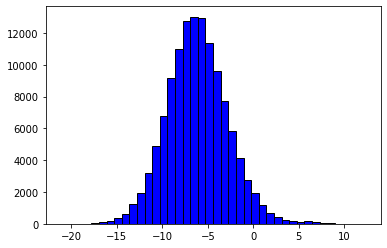

In [36]:
plt.hist(imodel.predict(0), color = 'blue', edgecolor = 'black',
         bins = 40)

Now that we have the scores of all items for a given user, we need to identify the top-scored ones, i.e. those that we would present to the user. 

**Exercise**: Write a function `tracksForUser(user)` to identify the artist name & track of the top K (e.g. K=4) items based on their score for a given user index index (i.e. 0.. 964). Hint: Try SciPy's [rankdata](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.rankdata.html) function. I also found [np.argwhere](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argwhere.html) to be userful. Alternatively, you can sort and then slice.

What tracks are recommended for user uid 10.

In [0]:
from scipy.stats import rankdata

def tracksForUser(user, K=4):
  predictions = imodel.predict(user)
  ranks = rankdata(predictions, method='max')
  return np.argwhere(ranks>len(ranks)-K).reshape(K)

In [97]:
tracksForUser(10, K=4)

array([  3477,  10151,  10563, 123943])

**Exercise** Look at the artists actually listened to by uid 10, and compare/contrast with predictions. Hint use a groupby on a suitable subset of the listens_df dataframe. If you can, sort by descending frequency of listen.

I observed that uid 10 listened frequently to "The Smashing Pumpkins" (rank 1)  and "R.E.M." (rank 7), which arent too different to suggestions of "Radiohead".

## Evaluating an implicit recommender




We can examine the MRR of the implicit model we have learned. We pass it the test set (which contains knowledge of what the user *actually* clicked), as our ground truth. 

In the second variant, we also pass the training data. This prevents the recommender gaining credit for recommending items that were part of the training data for that user.

You can see the implementation of [mrr_score()](https://github.com/cmacdonald/spotlight/blob/master/spotlight/evaluation.py#L8).

**Questions for you to consider**
 - Why is the second score lower? 
 - Would this be the same for all recommendation settings? 
 - In the implementation, why are the scores negated, why do we use [rankdata()](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.rankdata.html)?
 
We will use the first variant for this Lab. 

In [0]:
from spotlight.evaluation import mrr_score

#evaluate on this dataset takes approx 1 minute
!date
print(mrr_score(imodel, itest).mean())
!date
print(mrr_score(imodel, itest,  train=itrain).mean())
!date



How to interpret an MRR score - we know it has a range [0,1] with 1 being best. 1 means, on average across all users, we make a relevant prediction at rank 1; 0.5 means, on average, at rank 2. This is a very rough rule-of-thumb - MRR isnt a linear measure, so  a few poor predictions affect the average more than a few good ones.

**Exercise**

*   Pick a user with the highest RR. How many listens did they have in the training dataset?
*   Similalry, pick a user with the lowest RR. How many listens did they have in the training dataset?



**Exercise**

Train an implicit model using the `loss="bpr"` option of ImplicitFactorizationModel. 
 
*   The loss function values are smaller. What can we interpret from that?
*   Compare its effectiveness. Is this result expected?




## End of lab

After you have completed the lab, please complete the [Lab 2 feedback quiz](https://moodle.gla.ac.uk/mod/feedback/view.php?id=1444707) on the RecSys Moodle page.



